# Used Car Prices Analysis

This notebook intends to explore the price of cars produced in different years and will try to calculate what brand is the most likely to have the most expensive car, produced in the year next to the last registered year in the dataset

File exploration

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Data extraction

In [18]:
cars_df = pd.read_csv('cars_price.csv')
cars_df.isna().any()

Unnamed: 0             False
make                   False
model                  False
priceUSD               False
year                   False
condition              False
mileage(kilometers)    False
fuel_type              False
volume(cm3)             True
color                  False
transmission           False
drive_unit              True
segment                 True
dtype: bool

Data transformation

As there are no null values in columns of interest dropping rows with empty values is not necessary

In [20]:
cars_df['make_count'] = cars_df.groupby('make')['make'].transform('count')
cars_df[cars_df['make_count'] == 3]

,Unnamed: 0,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment,make_count
184,184,changan,cs35,9999,2017,with mileage,54000.0,petrol,1600.0,white,mechanics,front-wheel drive,NaN,3
6645,6645,haval,h9,29000,2018,with mileage,17000.0,petrol,2000.0,black,auto,all-wheel drive,NaN,3
10350,10350,wartburg,353,1200,1990,with mileage,70000.0,petrol,1300.0,orange,mechanics,front-wheel drive,NaN,3
13733,13733,changan,cs35,8500,2015,with mileage,17700.0,petrol,1600.0,blue,mechanics,front-wheel drive,NaN,3
17562,17562,faw,besturn-b50,4300,2012,with mileage,106000.0,petrol,1600.0,gray,auto,front-wheel drive,NaN,3
17712,17712,faw,besturn-b50,2750,2012,with mileage,1.0,petrol,1600.0,silver,mechanics,front-wheel drive,NaN,3
19813,19813,faw,besturn-b50,5500,2012,with mileage,95000.0,petrol,1600.0,silver,auto,front-wheel drive,NaN,3
20725,20725,wartburg,353,1000,1990,with mileage,76657.0,petrol,1300.0,other,mechanics,front-wheel drive,NaN,3
25606,25606,changan,cs35,9500,2017,with mileage,40571.0,petrol,1600.0,brown,mechanics,front-wheel drive,NaN,3
36330,36330,haval,h2,13650,2015,with mileage,40000.0,petrol,1500.0,brown,mechanics,part-time four-wheel drive,NaN,3


As there are records that only have one only year, linear regression won't be possible; these records will be deleted

In [23]:
def mark_for_deletion(series):
  
    return len(set(series)) == 1
    
#conteos = cars_df.groupby('make')['year'].value_counts()
#conteos
cars_df['deletion'] = cars_df.groupby('make')['year'].transform(mark_for_deletion)
deletion_rows = cars_df[cars_df['deletion']]
print(f'Deleting {len(deletion_rows)} records with only one registering production year')
cars_df.drop(deletion_rows.index, inplace = True)

Deleting 22 records with only one registering production year



Visualizing the different makes and their prices per year of production


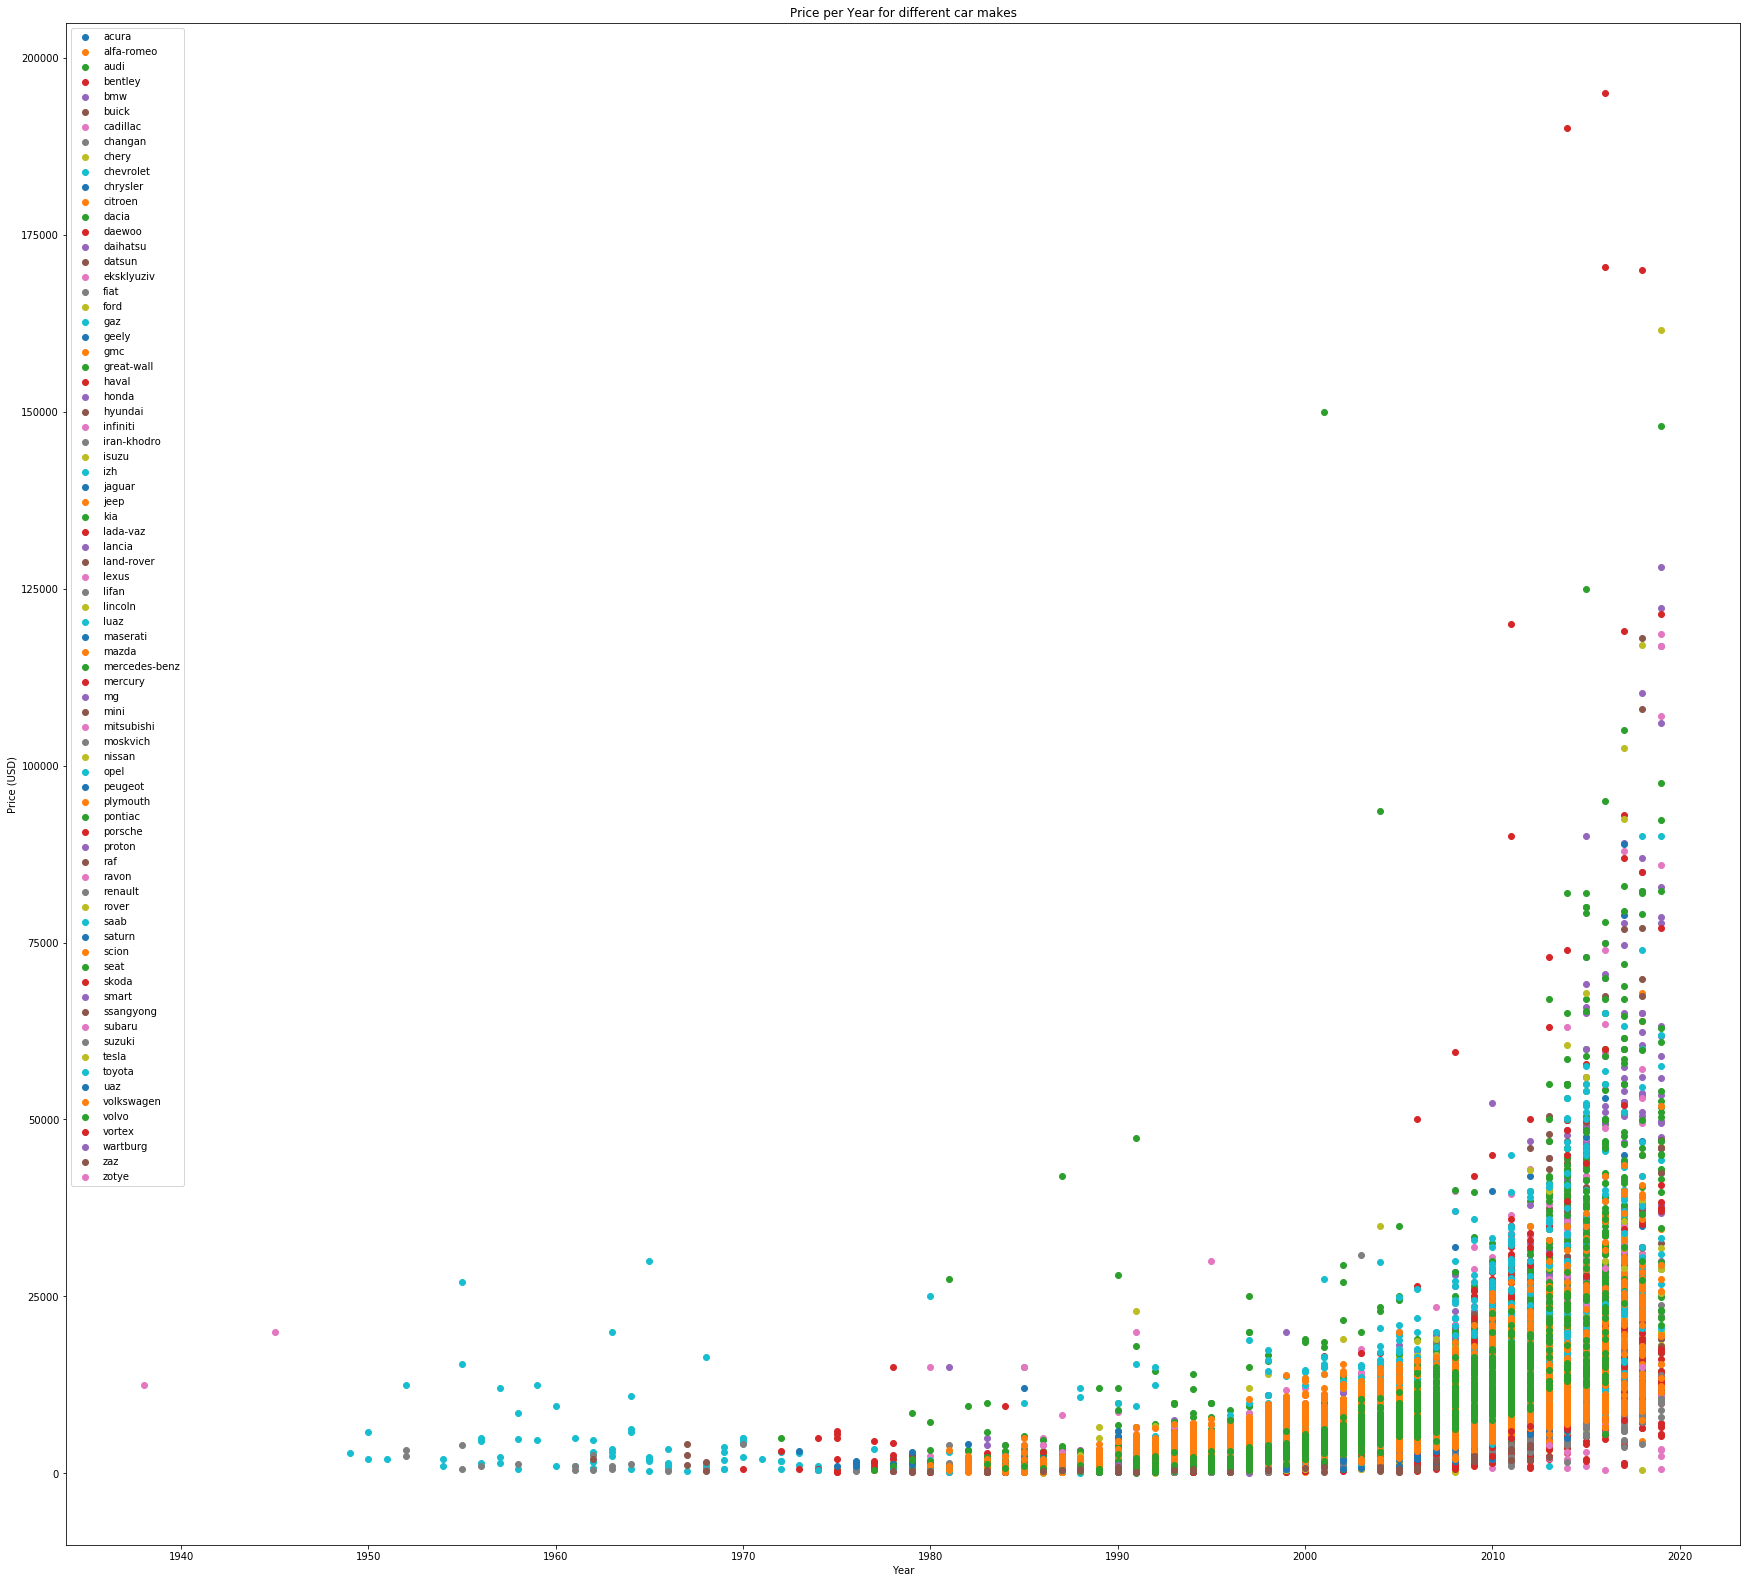

In [25]:
import matplotlib.pyplot as plt


def plot_makes(df, xlabel = 'Year', ylabel = 'Price (USD)', title = 'Price per Year for different car makes'):
    _, ax = plt.subplots(figsize = (30,28))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)    
    ax.set_title(title)
    for make, make_df in cars_df.groupby('make'):        
        ax.scatter(make_df['year'], make_df['priceUSD'], label = make)
    ax.legend()


plot_makes(cars_df)

Analyzing which car make yields the highest expected price for the next year

In [27]:
next_year = cars_df['year'].max() + 1
print(f'Year of prediction: {next_year}')

Year of prediction: 2020


In [28]:
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot


def plot_regression_prediction(x, y, x_pred, y_pred, regression, xlabel = '', ylabel = '', title = ''):
    fig, ax = plt.subplots(figsize = (30,21))
    ax.scatter(x, y, label = 'real')
    ax.scatter(x_pred, y_pred, label = f'{make} prediction')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    abline_plot(model_results = regression, ax = ax)
    

def obtain_make_regression_model(make):
    """
    Returns the fit OLS linear regression instance for a make
    """
    make_df = cars_df[cars_df['make'] == make]
    
    y = make_df['priceUSD']
    x = make_df['year']

    x_pred = pd.DataFrame([next_year, next_year + 1])
    return sm.OLS(y, sm.add_constant(x)).fit()


def get_regressions_dataframe(df, x_pred):
    reg_df = pd.DataFrame(columns = ['make','prediction'])
    reg_df['make'] = cars_df['make'].unique()
    reg_df.set_index('make', inplace = True)

    for make in reg_df.index:
        linear_regression = obtain_make_regression_model(make)
        reg_df.loc[make, 'prediction'] = linear_regression.predict(sm.add_constant(x_pred))[0]

    return reg_df


reg_df = get_regressions_dataframe(cars_df, [next_year, next_year + 1])

max_price_car = reg_df[reg_df['prediction'] == reg_df['prediction'].max()]

print(f'The car make with the highest expected price for {next_year} is {max_price_car.index[0]}, with a price of {max_price_car["prediction"].values[0]:.2f} USD')


The car make with the highest expected price for 2020 is bentley, with a price of 248869.48 USD


In [29]:
max_price_car_df = cars_df[cars_df['make'] == max_price_car.index[0]]
max_price_car_df

,Unnamed: 0,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment,make_count,deletion
16701,16701,bentley,mulsanne,190141,2014,with mileage,36500.0,petrol,6750.0,purple,auto,rear drive,NaN,7,False
19607,19607,bentley,bentayga,170477,2016,with mileage,74100.0,petrol,6000.0,other,auto,all-wheel drive,NaN,7,False
24809,24809,bentley,continental-gt,42000,2009,with mileage,98000.0,petrol,6000.0,white,auto,all-wheel drive,NaN,7,False
25355,25355,bentley,continental-gt,73000,2013,with mileage,73000.0,petrol,4000.0,white,auto,all-wheel drive,NaN,7,False
27207,27207,bentley,continental-flying-spur,26500,2006,with mileage,140000.0,petrol,6000.0,blue,auto,all-wheel drive,NaN,7,False
30227,30227,bentley,mulsanne,120000,2011,with mileage,178471.0,petrol,6800.0,gray,auto,all-wheel drive,NaN,7,False
33169,33169,bentley,bentayga,195000,2016,with mileage,72000.0,petrol,6000.0,other,auto,all-wheel drive,NaN,7,False


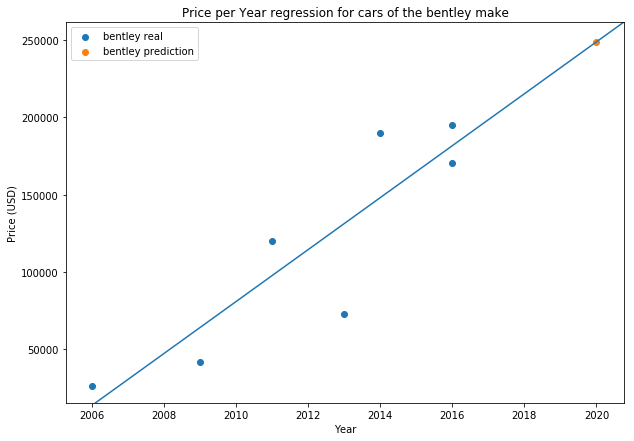

In [30]:
def plot_regression_prediction(x, y, x_pred, y_pred, regression, make = ''):
    fig, ax = plt.subplots(figsize = (10,7))
    ax.scatter(x, y, label = f'{make} real')
    ax.scatter(x_pred, y_pred, label = f'{make} prediction')
    ax.set_xlabel('Year')
    ax.set_ylabel('Price (USD)')
    ax.set_title(f'Price per Year regression for cars of the {make} make')
    ax.legend()
    abline_plot(model_results = regression, ax = ax)

reg = obtain_make_regression_model(max_price_car.index[0])
    
plot_regression_prediction(max_price_car_df['year'], max_price_car_df['priceUSD'], next_year, max_price_car['prediction'], reg, make = max_price_car.index[0])
